In [1]:
#DB
# import os
import psycopg2

# Helpers
import numpy as np
import time
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

## Connect to DB

In [2]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "vw_$Z^vBgn?7H{z4",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [31]:
def get_where_items(exp_id, cols):
    query = "SELECT %s from experiments_solution where experiment_id = %s" % (", ".join(cols), exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def get_variation_values(cols_to_query, params, params_values):
    cols_to_query = cols_to_query[:]
    cols_to_retrieve = [
#             "experiment_id", "dataset", "K"
            "coherence_samples5", "coherence_med5", "coherence_std5", "coherence_k5",
            "coherence_samples10", "coherence_med10", "coherence_std10", "coherence_k10",
            "coherence_samples15", "coherence_med15", "coherence_std15", "coherence_k15"] + cols_to_query
    for item in params:
        param_idx = cols_to_query.index(item)
        del cols_to_query[param_idx]
        del params_values[param_idx]
    
    query = "SELECT %s from experiments_solution where " % ", ".join(cols_to_retrieve)
    where_clause = []
    for idx, item in enumerate(cols_to_query):
        where_clause.append((item, params_values[idx]))
    query += " AND ".join(["%s = '%s'" % item for item in where_clause])
    query += "order by %s" % ",".join(params)
    cursor.execute(query)
    r = cursor.fetchall()
    df = pd.DataFrame(r, columns=cols_to_retrieve)
    return df

def plot_coherence(data, coherence_field, param, param_label, coherence_label, min_val=None):
    coherence_array = data[coherence_field].tolist()
    param_array = data[param].tolist()
    plt.figure(figsize=(8,6))
    df_boxplot = []
    for idx, i in enumerate(coherence_array):
        median = np.median([item for item in i if str(item) != 'nan'])
        if min_val:
            value = [item for item in i if item > min_val]
        else:
            value = i
        plt.scatter([idx]*len(value), value)
        for item in value:
            df_boxplot.append((item, param_array[idx]))
    
    df_boxplot = pd.DataFrame(df_boxplot, columns=['coherence', param])
    ax = sns.boxplot(x=param, y="coherence", data=df_boxplot)
    plt.xlabel(param_label)
    plt.ylabel(coherence_label)
    plt.grid(alpha=0.3)
    
def plot_coherence2d(data, coherence_field, params, params_label, coherence_label, min_val=None, **kwargs):
    cmap = sns.cubehelix_palette(as_cmap=True)
    x = data[params[0]].tolist()
    y = data[params[1]].tolist()
    median_array = []
    iqr_array = []
    # Get all medians and iqrs
    for row in data.iterrows():
        coherence_array = row[1][coherence_field]
        coherence_clean = [item for item in coherence_array if str(item) != 'nan']
        median = np.median(coherence_clean)
        median_array.append(median)
        q75, q25 = np.percentile(coherence_clean, [75, 25])
        iqr = q75 - q25
        iqr_array.append(iqr)
        
    # Normalize median to be between 10 and 1500 
    s_max = 1500
    s_min = 10
    median_max = np.asarray(median_array).max()
    median_min = max(np.asarray(median_array).min(), kwargs.get("median_min", -100))
    print(median_min)
    scale = lambda x: (x-median_min)*(s_max-s_min)/(median_max-median_min)+s_min
    median_scaled = [scale(max(item, kwargs.get("median_min", -100))) for item in median_array]
    
    # Plot data
    f, ax = plt.subplots(figsize=kwargs.get("figsize", (4,3)))
    points = ax.scatter(x, y, c=iqr_array, s=median_scaled,
                       cmap=cmap, alpha=0.6)
    cbar = f.colorbar(points)
#     cbar.set_label('Coherence variance', rotation=270)
    
    # Plot legend
    try:
        for method in kwargs["plt_args"]:
            method_to_call = getattr(plt, method)
            method_to_call(*kwargs["plt_args"][method])
    except KeyError:
        pass
    try:
        for method in kwargs["plt_kwargs"]:
            method_to_call = getattr(plt, method)
            method_to_call(**kwargs["plt_kwargs"][method])
    except KeyError:
        pass
    plt.xticks(rotation=25)
    plt.xlabel(params_label[0])
    plt.ylabel(params_label[1])
    plt.title(coherence_label)
    plt.tight_layout()
    return median_array, iqr_array
    
def compare_values(cols_to_query, params, param_label, where_items, cutoff=[-10,-10,-10]):
    data = get_variation_values(cols_to_query, params, list(where_items[0]))
    for idx, N in enumerate(range(5,16,5)):
        plot_coherence(data, "coherence_samples%d" % N, params[0], param_label, 
                       "Coherence for Top-%d terms" % N, cutoff[idx])

-0.360223


<IPython.core.display.Javascript object>


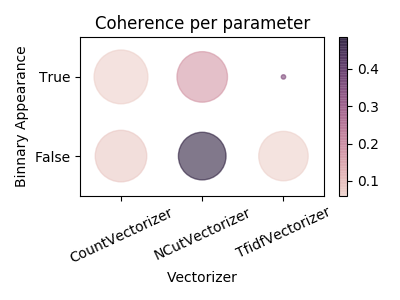

([-0.026899260999999997,
  -0.0761055,
  -0.0538498,
  0.003207545,
  -0.040281510000000006,
  -0.360223],
 [0.0782193725,
  0.48405133,
  0.06063558249999999,
  0.062695605,
  0.1724412375,
  0.34989700000000007])

In [6]:
config = {
#     "median_min": -0.1,
    "plt_args": {
        "xlim": (-0.5, 2.5),
        "ylim": (-0.5, 1.5),
        "yticks": ([0,1], ("False", "True"))
    },
    "plt_kwargs": {
        "xticks": {"rotation": 25},
    }
}
data = get_variation_values(cols_to_query, ["is_binary", "vectorizer"], list(where_items[0]))
plot_coherence2d(data, "coherence_samples5", ["vectorizer", "is_binary"], 
                 ["Vectorizer","Binnary Appearance"], "Coherence per parameter", **config)

-0.03


<IPython.core.display.Javascript object>


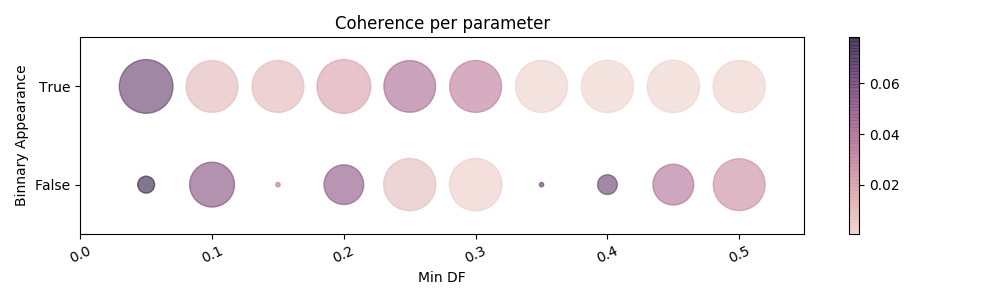

In [7]:
config = {
    "figsize": (10,3),
     "plt_args": {
        "ylim": (-0.5, 1.5),
        "yticks": ([0,1], ("False", "True")),
    },
    "median_min": -0.03
}
data = get_variation_values(cols_to_query, ["is_binary", "min_df"], list(where_items[0]))
ma, iqr = plot_coherence2d(data, "coherence_samples5", ["min_df", "is_binary"], 
                 ["Min DF","Binnary Appearance"], "Coherence per parameter", **config)

-0.1


<IPython.core.display.Javascript object>


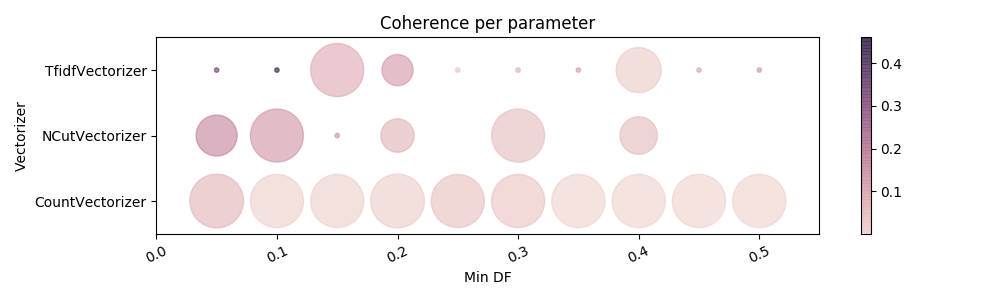

In [8]:
config = {
    "figsize": (10,3),
    "plt_args": {
        "ylim": (-0.5, 2.5),
    },
    "median_min": -0.1,
}
data = get_variation_values(cols_to_query, ["vectorizer", "min_df"], list(where_items[0]))
ma, iqr = plot_coherence2d(data, "coherence_samples5", ["min_df", "vectorizer"], 
                 ["Min DF","Vectorizer"], "Coherence per parameter", **config)

-0.399212


<IPython.core.display.Javascript object>


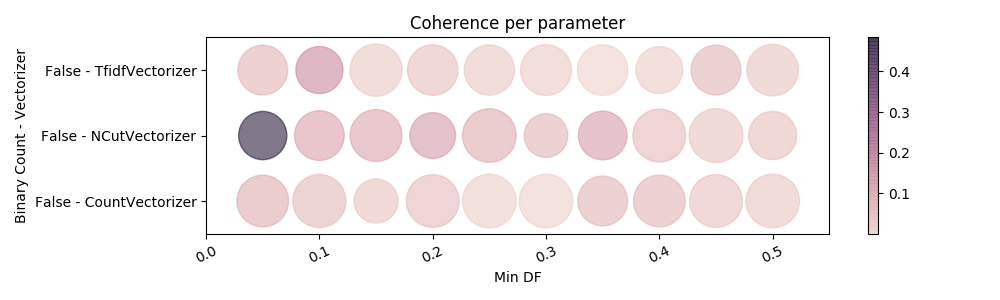

['False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - CountVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - NCutVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'False - TfidfVectorizer', 'True - CountVectorizer', 'True - CountVectorizer', 'True - CountVectorizer', 'True - CountVectorizer', 'True - CountVectorizer', 'True - CountVectorizer', 'True - CountVectorizer', 'True - CountVect

In [33]:
config = {
    "figsize": (10,3),
    "plt_args": {
        "ylim": (-0.5, 2.5),
    },
#     "median_min": -0.1,
}
data = get_variation_values(cols_to_query, ["is_binary", "vectorizer", "min_df"], list(where_items[0]))
data["param"] = data[["is_binary", "vectorizer"]].apply(lambda x: "%s - %s" % (x["is_binary"], x["vectorizer"]), axis=1)
ma, iqr = plot_coherence2d(data, "coherence_samples5", ["min_df", "param"], 
                 ["Min DF","Binary Count - Vectorizer"], "Coherence per parameter", **config)

## Experiment 26

In [5]:
exp_id = 26
cols_to_query = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset", "k"]
where_items = get_where_items(exp_id, cols_to_query)
print("Parameters")
print(list(where_items[0]))

Parameters
['CountVectorizer', 0.05, True, 'euclidean', 'lda', 'solution_all', 12]


Minimum Document Frequency

<IPython.core.display.Javascript object>


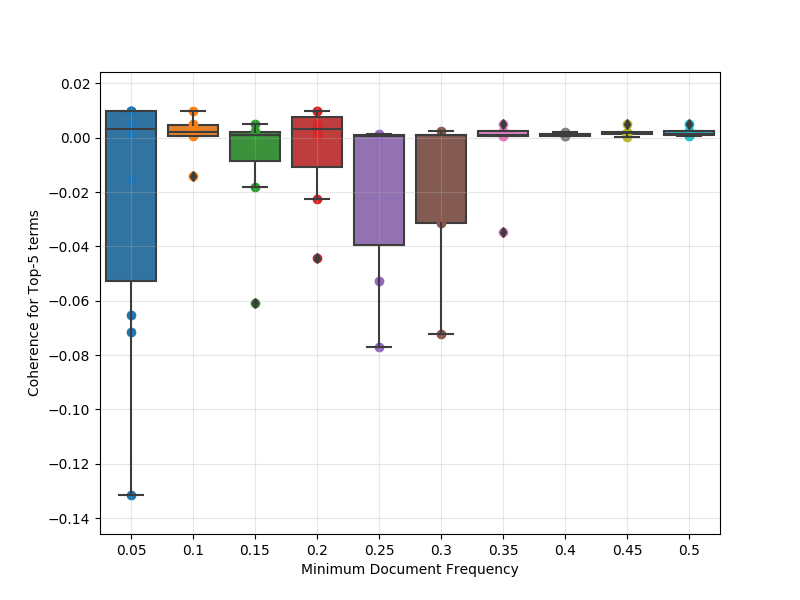

<IPython.core.display.Javascript object>


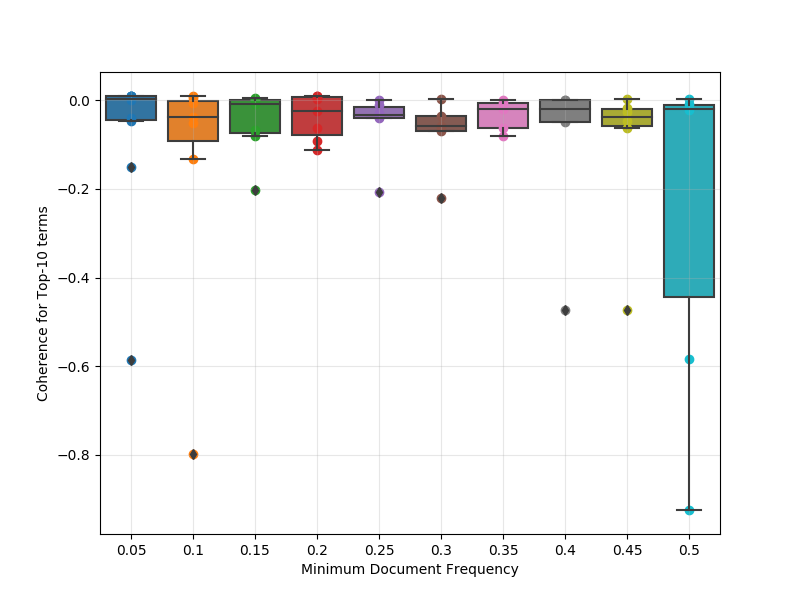

<IPython.core.display.Javascript object>


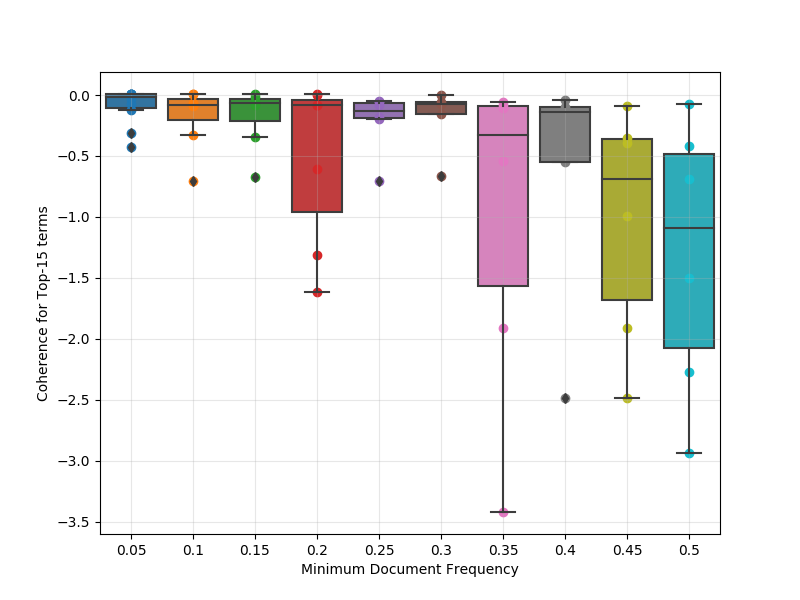

In [249]:
compare_values(cols_to_query, ["min_df"], "Minimum Document Frequency", where_items, [-1.75,-1.75,-10])

Binary Appearance

<IPython.core.display.Javascript object>


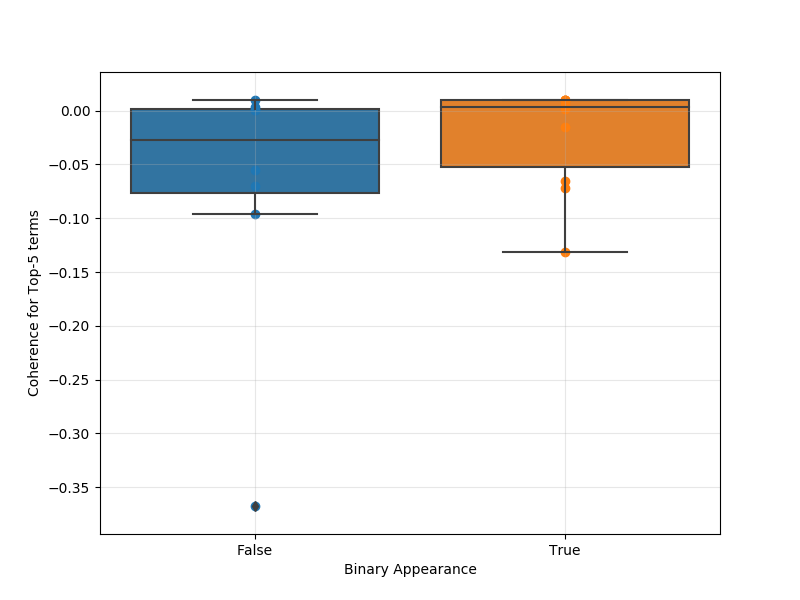

<IPython.core.display.Javascript object>


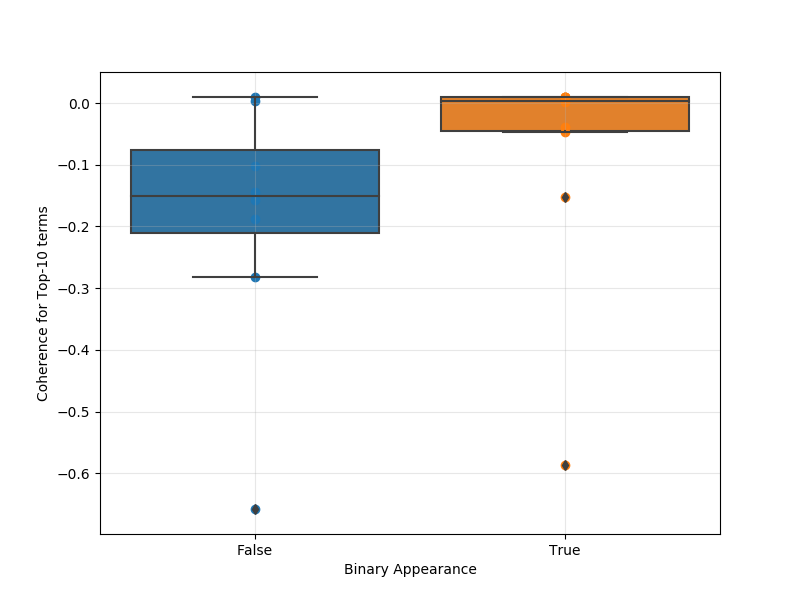

<IPython.core.display.Javascript object>


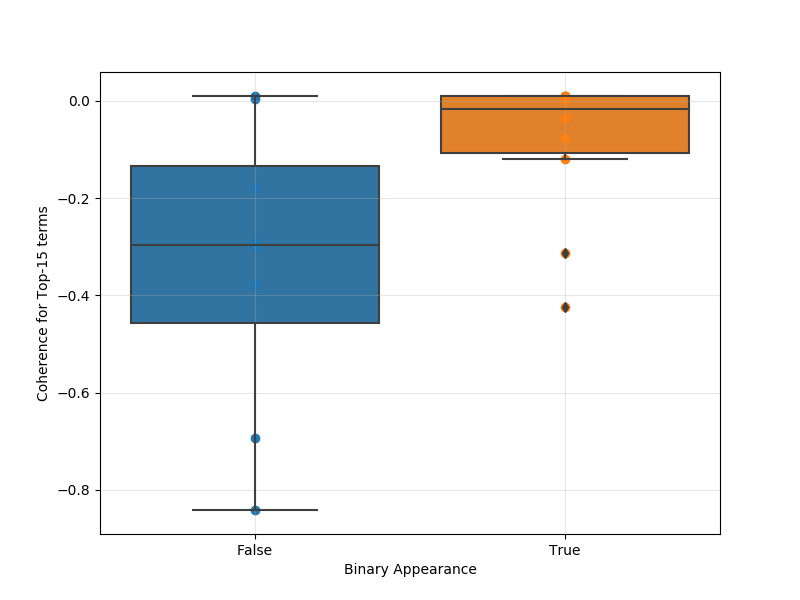

In [205]:
compare_values(cols_to_query, "is_binary", "Binary Appearance", where_items, [-100,-100,-100])

Vectorizer

<IPython.core.display.Javascript object>


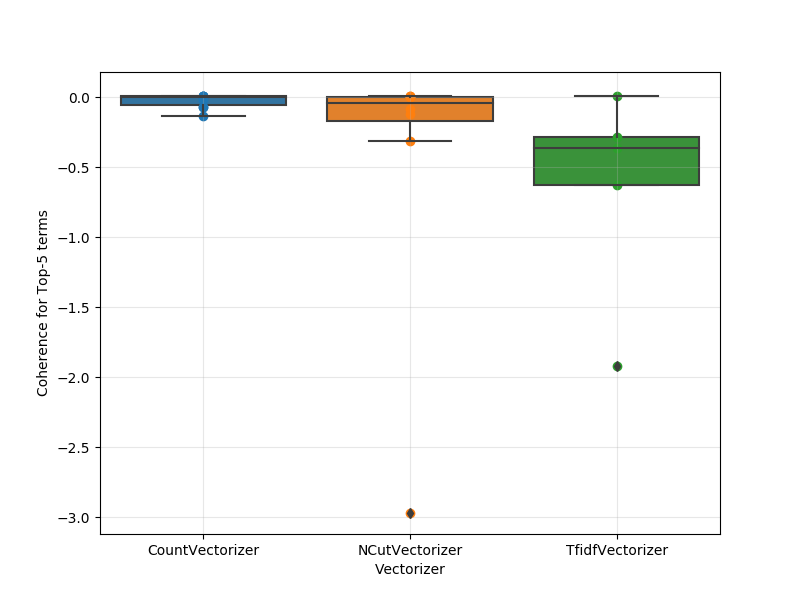

<IPython.core.display.Javascript object>


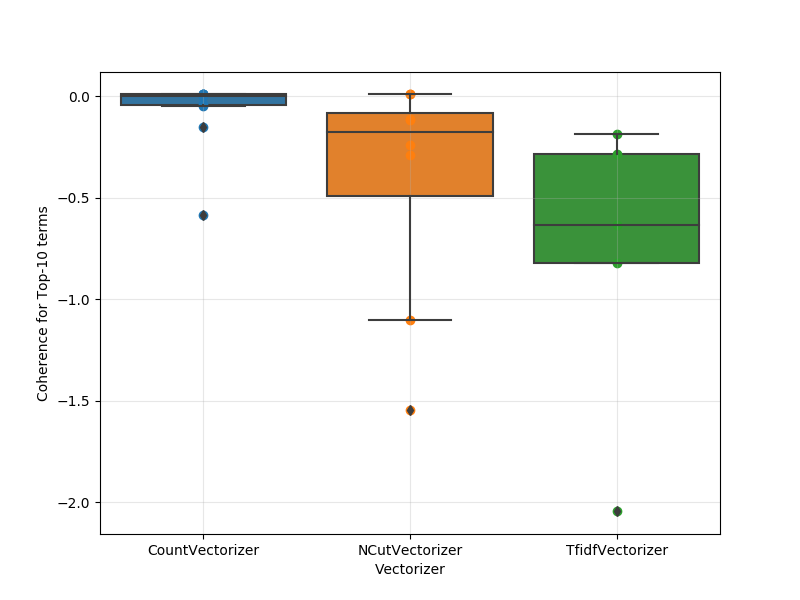

<IPython.core.display.Javascript object>


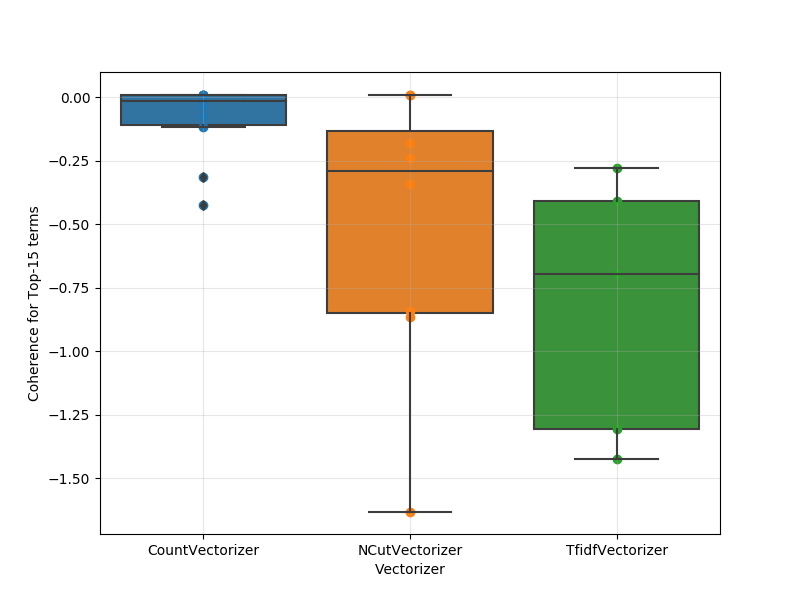

In [206]:
compare_values(cols_to_query, "vectorizer", "Vectorizer", where_items, [-100,-100,-100])

Number of clusters

<IPython.core.display.Javascript object>


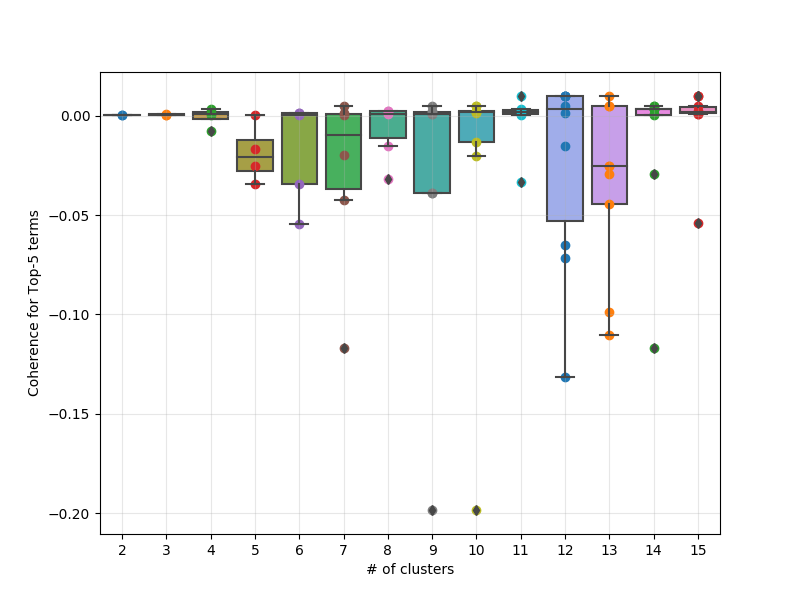

<IPython.core.display.Javascript object>


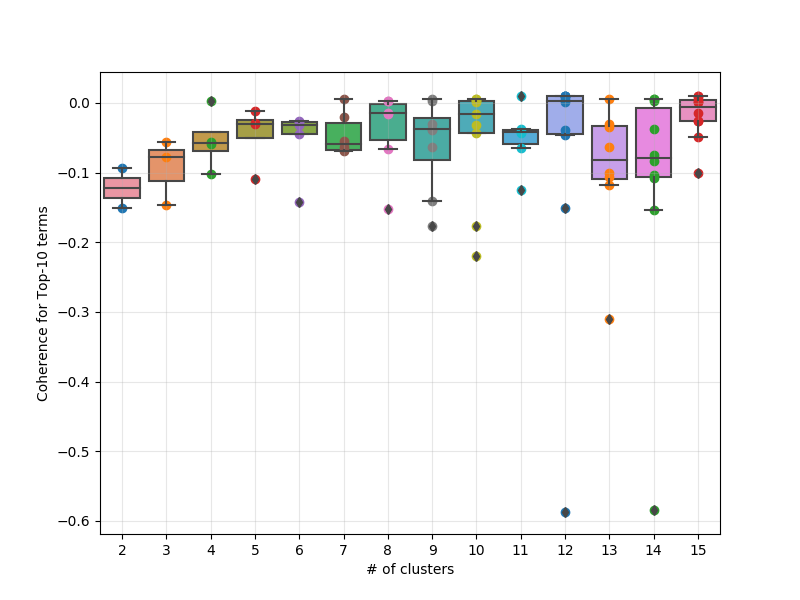

<IPython.core.display.Javascript object>


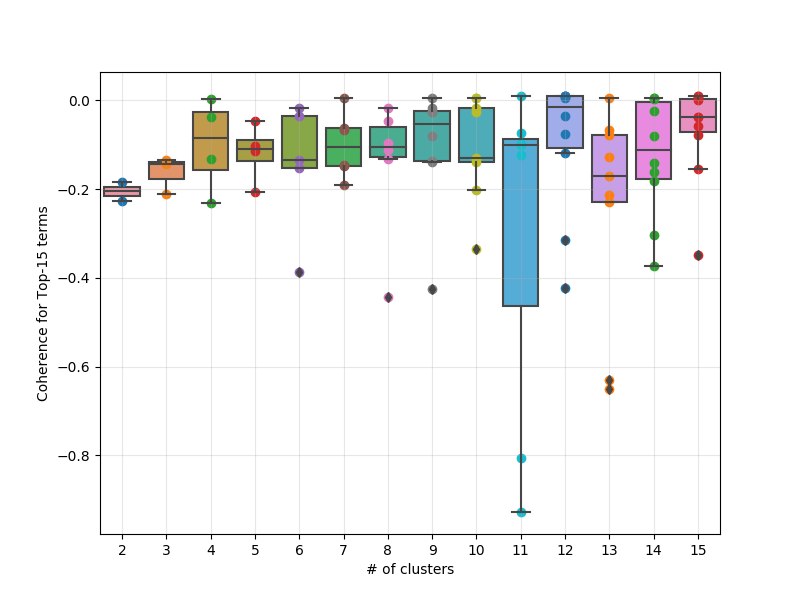

In [217]:
compare_values(cols_to_query, "k", "# of clusters", where_items, [-1,-1,-100])

Method

In [236]:
compare_values(cols_to_query, "method", "Method", where_items, [-100,-100,-100])

,coherence_samples5,coherence_med5,coherence_std5,coherence_k5,coherence_samples10,coherence_med10,coherence_std10,coherence_k10,coherence_samples15,coherence_med15,coherence_std15,coherence_k15,vectorizer,min_df,is_binary,distance,method,dataset,k
0,"[-0.131657, 0.00995033, 0.00995033, 0.00498754...",0.003208,0.046606,10,"[-0.586776, 0.00995033, 0.00995033, 0.00498754...",0.003208,0.176320,10,"[-0.313694, 0.00995033, 0.00995033, 0.00498754...",-0.015485,0.146244,10,CountVectorizer,0.05,True,euclidean,lda,solution_all,12
1,"[0.0009995, -0.0972274, 0.00498754, 0.00249688...",0.002497,0.037721,12,"[-0.107027, -0.0997382, 0.00498754, 0.00249688...",-0.017493,0.057683,12,"[-0.336761, -0.138779, 0.00498754, -0.0329072,...",-0.044177,0.121836,12,CountVectorizer,0.05,True,euclidean,nmf,solution_all,12


## Experiment 1463

In [233]:
exp_id = 1463
cols_to_query = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset", "k"]
where_items = get_where_items(exp_id, cols_to_query)
print("Parameters")
print(list(where_items[0]))

Parameters
['NCutVectorizer', 0.35, True, 'euclidean', 'nmf', 'solution_all', 7]


Minimum Document Frequency

<IPython.core.display.Javascript object>


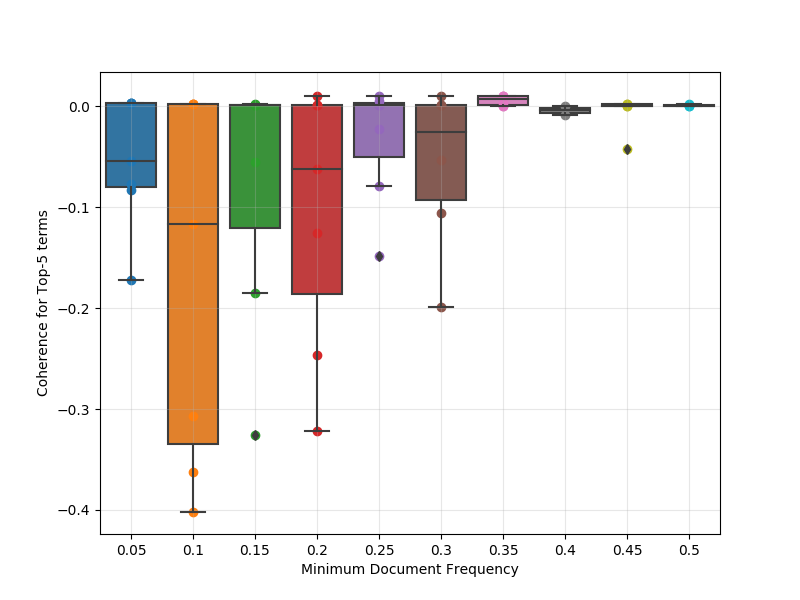

<IPython.core.display.Javascript object>


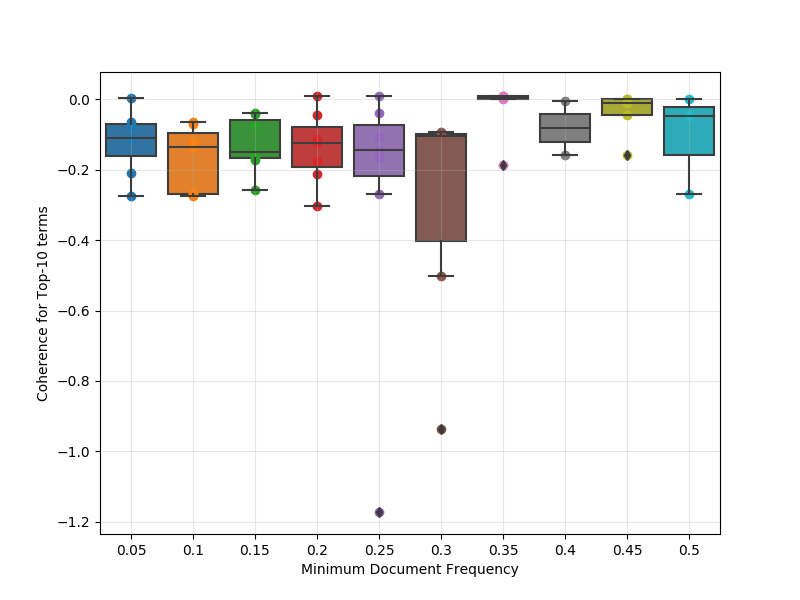

<IPython.core.display.Javascript object>


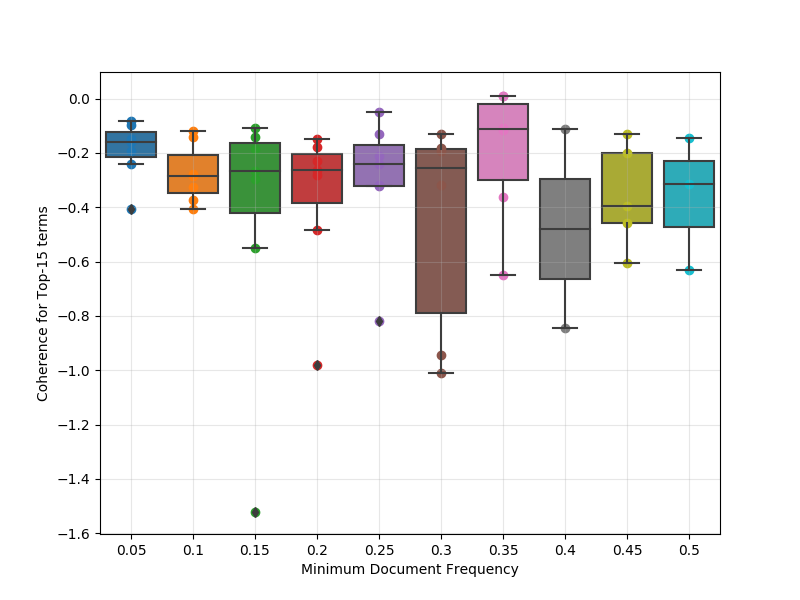

In [220]:
compare_values(cols_to_query, "min_df", "Minimum Document Frequency", where_items, [-100,-100,-100])

<IPython.core.display.Javascript object>


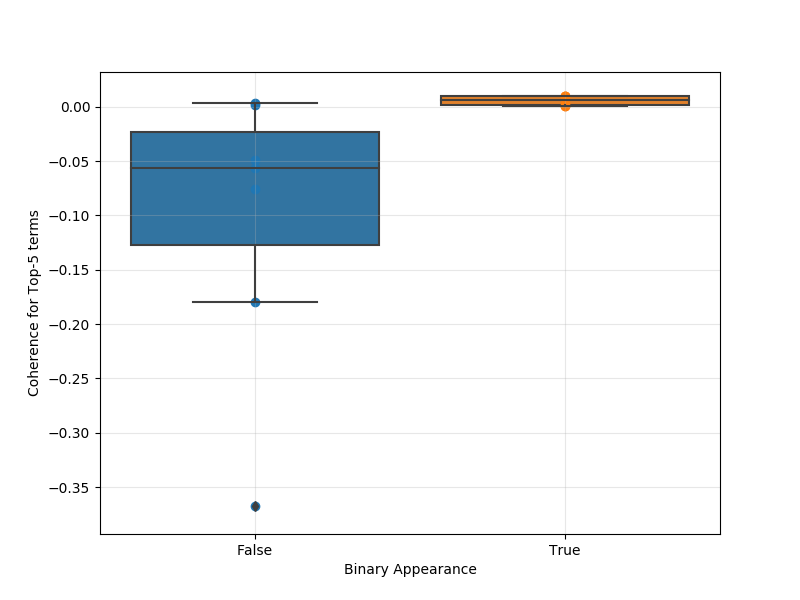

<IPython.core.display.Javascript object>


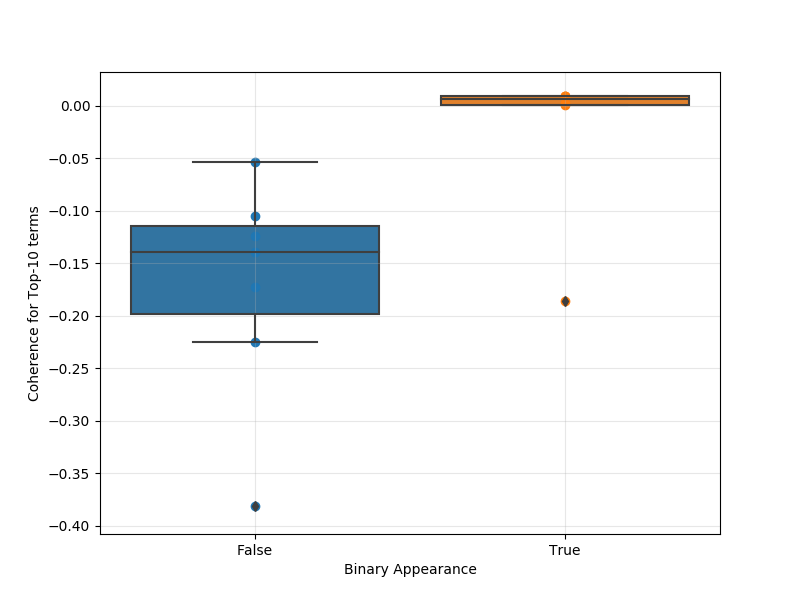

<IPython.core.display.Javascript object>


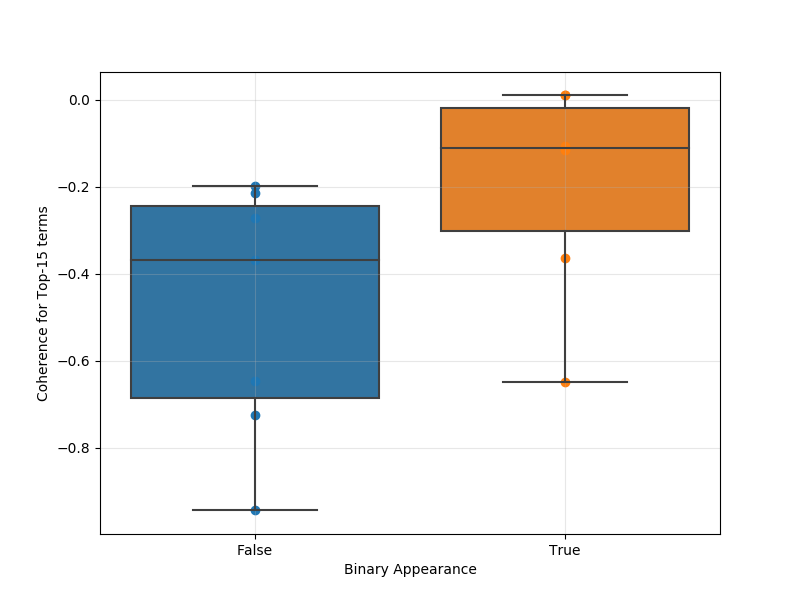

In [221]:
compare_values(cols_to_query, "is_binary", "Binary Appearance", where_items, [-100,-100,-100])

Vectorizer

<IPython.core.display.Javascript object>


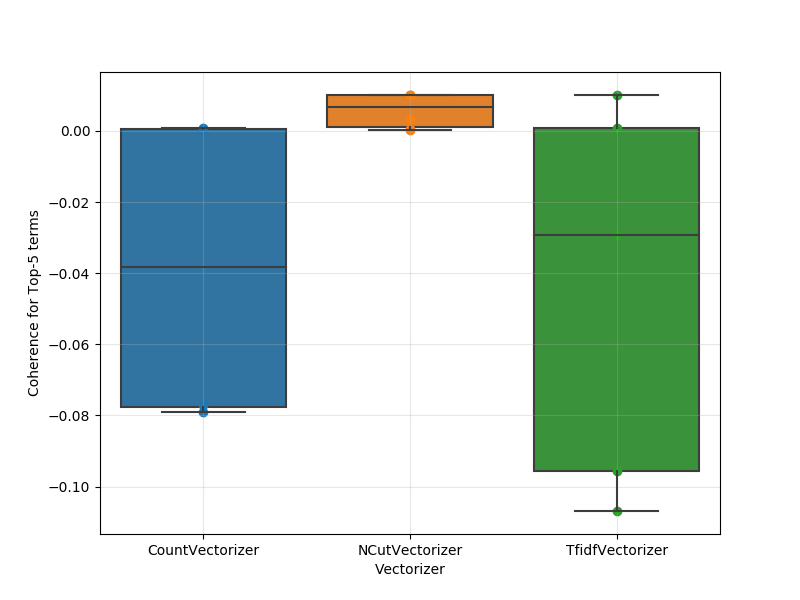

<IPython.core.display.Javascript object>


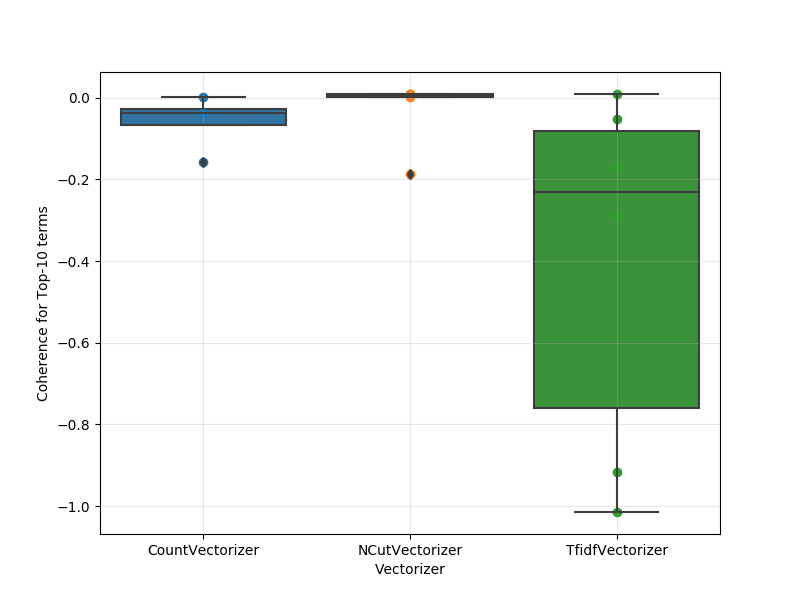

<IPython.core.display.Javascript object>


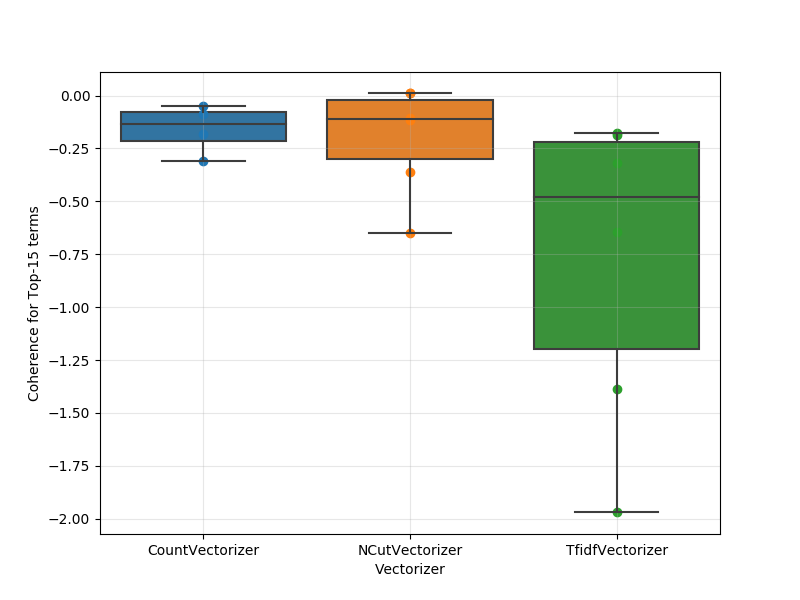

In [223]:
compare_values(cols_to_query, "vectorizer", "Vectorizer", where_items, [-2,-100,-100])

Number of clusters

<IPython.core.display.Javascript object>


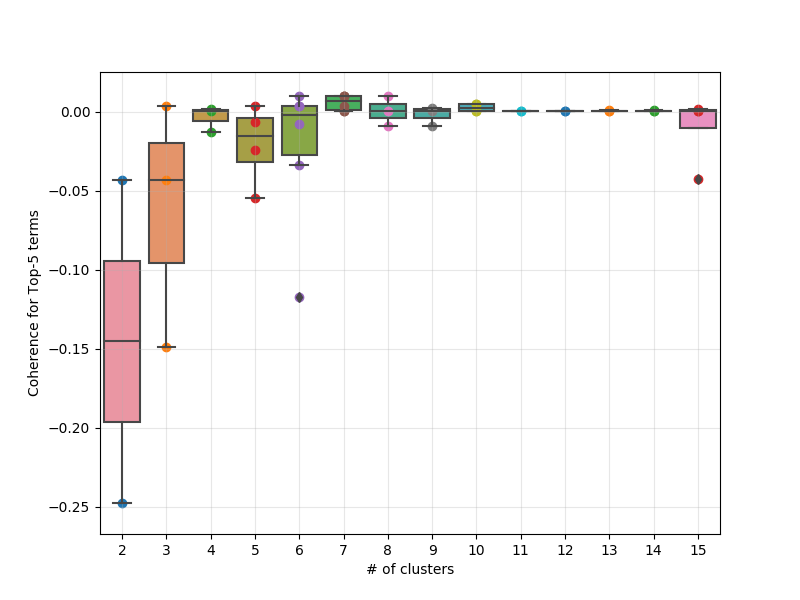

<IPython.core.display.Javascript object>


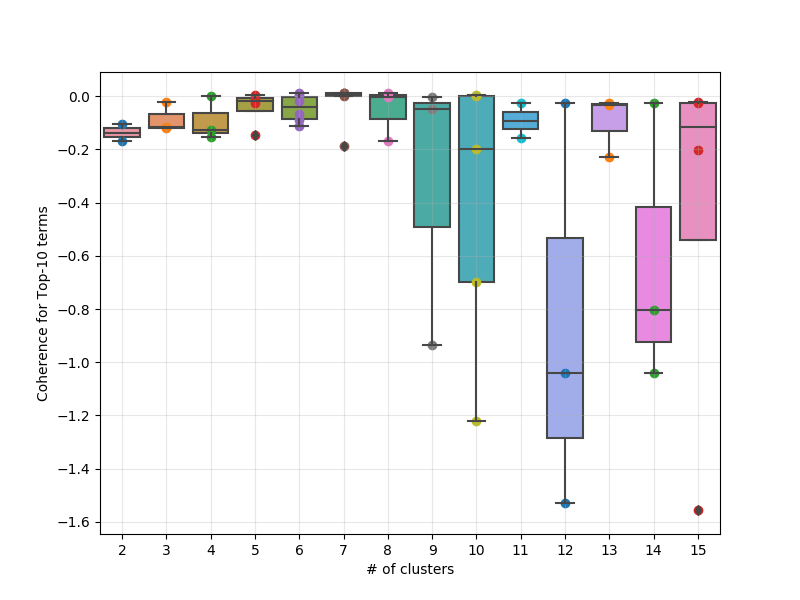

<IPython.core.display.Javascript object>


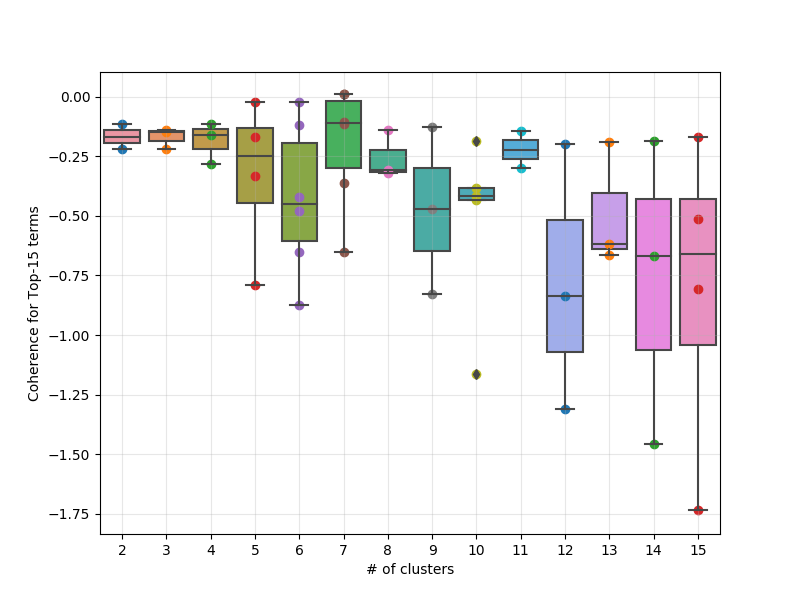

In [225]:
compare_values(cols_to_query, "k", "# of clusters", where_items, [-1,-100,-100])